# 1D simulation of protons

In [1]:
from crpropa import *


def simulate(A, Z, nEvents = 100000):
	# general options
	neutrinos = True
	photons = electrons = False
	energyRange = (1000 * EeV,1000 * EeV)
	distanceRange = (0., 4000. * Mpc)
	cmb = CMB()
	ebl = IRB_Dominguez11()
	outputFileCR = '05-sim1D-A_%02i_Z_%02i-CR.txt' % (A, Z)
	outputFileNu = '05-sim1D-A_%02i_Z_%02i-Nu.txt' % (A, Z)

	# source distribution: uniform with power-law spectrum
	position = SourceUniform1D(*distanceRange)
	direction = SourceDirection(Vector3d(-1, 0, 0)) # emit in the -x direction (1D simulation)
	redshifts = SourceRedshift1D() # takes the positions and assign the corresponding redshifts
	energySpectrum = SourcePowerLawSpectrum(*energyRange, -1)
	particleType = SourceParticleType(nucleusId(A, Z))
	source = Source()
	source.add(position)
	source.add(redshifts) 
	source.add(direction)
	source.add(energySpectrum)
	source.add(particleType)

	# outputs
	outputType = Output.Event1D
	outputCR = TextOutput(outputFileCR, outputType)
	outputCR.setEnergyScale(eV)
	outputCR.setLengthScale(Mpc)
	outputNu = TextOutput(outputFileNu, outputType)
	outputNu.setEnergyScale(eV)
	outputNu.setLengthScale(Mpc)

	# observers (for CRs and for neutrinos) 
	# observerType = Observer1D()
	observerType = Observer1D()
	neutrinoVeto = ObserverNeutrinoVeto()
	nucleusVeto = ObserverNucleusVeto()
	photonVeto = ObserverPhotonVeto()
	electronVeto = ObserverElectronVeto()
	observerCR = Observer()
	observerCR.add(observerType)
	observerCR.add(neutrinoVeto)
	observerCR.add(photonVeto)
	observerCR.add(electronVeto)
	observerCR.onDetection(outputCR)
	observerNu = Observer()
	observerNu.add(observerType)
	observerNu.add(nucleusVeto)
	observerNu.add(photonVeto)
	observerNu.add(electronVeto)
	observerNu.onDetection(outputNu)

	# interactions: photodisintegration
	pdCMB = PhotoDisintegration(cmb)
	pdCMB.setHavePhotons(photons)
	pdEBL = PhotoDisintegration(ebl)
	pdEBL.setHavePhotons(photons)

	# interactions: photopion production
	pppCMB = PhotoPionProduction(cmb)
	pppCMB.setHavePhotons(photons)
	pppCMB.setHaveElectrons(electrons)
	pppCMB.setHaveNeutrinos(neutrinos)
	pppEBL = PhotoPionProduction(ebl)
	pppEBL.setHavePhotons(photons)
	pppEBL.setHaveElectrons(electrons)
	pppEBL.setHaveNeutrinos(neutrinos)

	# interactions: Bethe-Heitler pair production
	eppCMB = ElectronPairProduction(cmb)
	eppCMB.setHaveElectrons(electrons)
	eppEBL = ElectronPairProduction(ebl)
	eppEBL.setHaveElectrons(electrons)

	# decays
	nd = NuclearDecay()
	nd.setHavePhotons(photons)
	nd.setHaveElectrons(electrons)
	nd.setHaveNeutrinos(neutrinos)

	# adiabatic losses
	z = Redshift()

	# creating a list with all processes
	# processes = [pdCMB, pdEBL, pppCMB, pppEBL, eppCMB, eppEBL, nd, z]
	
	processes = [pdCMB, pdEBL,nd,z]

	# propagator: one-dimensional
	propagator = SimplePropagation(0.1 * kpc, 1 * Mpc)

	# break condition:  
	#  neutrinos: we are studying ~PeV-EeV energies, so E>10 TeV is suitable
	#  we are not interested in UHECRs with E<1 EeV
	breakEnergy = MinimumEnergyPerParticleId(1 * EeV) # global minimum energy 
	breakEnergy.add( 12, 10 * TeV) # Electron Neutrino 
	breakEnergy.add(-12, 10 * TeV) #Eclectron Antineutrino
	breakEnergy.add( 14, 10 * TeV) #Muon Neutrino
	breakEnergy.add(-14, 10 * TeV) #Muon Antineutrino
	breakEnergy.add( 16, 10 * TeV) #Tau Neutrino
	breakEnergy.add(-16, 10 * TeV) #Tau Antineutrino


	# assemble simulation components
	sim = ModuleList()
	sim.add(propagator)
	for interaction in processes:
		sim.add(interaction)
	sim.add(observerCR)
	sim.add(observerNu)
	sim.add(breakEnergy)
	sim.setShowProgress(True)
	sim.run(source, nEvents, True)

	outputCR.close()
	outputNu.close()

	return outputFileCR, outputFileNu


simH_CR, simH_Nu = simulate( 56, 26)
# simN_CR, simN_Nu = simulate(14, 7)

crpropa::ModuleList: Number of Threads: 12
Run ModuleList


crpropa::ModuleList: Signal 2 (SIGINT/SIGTERM) received


KeyboardInterrupt: 

In [2]:
import numpy as np
import pandas as pd


def readSimulation(filename):
	"""
	Read a simulation and return a pandas dataframe with the output.
	"""
	# infer header names
	with open(filename, 'r') as f:
		line = f.readline()
		line = line.replace('\n', '').replace('#', '')
		names = line.split('\t')[1:]
	
	# read file
	df = pd.read_csv(filename, delimiter = '\t', comment = '#', names = names)

	return df

def reweightSimulation(df, alpha, Rmax, columnName = 'W1', alpha0 = 1.):
	"""
	Given a pandas dataframe with the simulation, this function the correct weights (called `W1`)
	The simulation is assumed to have a spectrum E^-a0, with a0=1 in this case.

	# Input
	. `df`: pandas dataframe containing the simulations \\
	. `alpha`: desired spectral index \\
	. `Rmax`: spectrum cuts off above Z Rmax, where Z is the atomic number of the nucleus \\
	. `columnName`: name of the column to be created; defaults to 'W1' \\
	. `alpha0`: injection spectrum used in the simulation \\
	"""
	# compute weights for reweighting procedure
	computeWeight = lambda e0, z0: e0 ** (alpha0 - alpha) * np.exp(- e0 / (z0 * Rmax))
	w = np.array([computeWeight(df['E0'][i], chargeNumber(int(df['ID0'][i]))) for i in range(len(df['E0']))])
	df[columnName] = w / np.sum(w)

def computeSpectra(dfCR, dfNu, columnName = 'W1'):
	"""
	For a reweighted dataframe with an existing column named 'columnName', computes the spectrum of neutrinos and CRs.
	These two computations are done together to ensure a self-consistent normalisation.

	# Input
	. `df`: the dataframe \\
	. `columnName`: the name of the column from where the weights will be taken \\
	"""
	binsCR = np.logspace(17, 21, 20)
	yCR, edgesCR = np.histogram(dfCR['E'], bins = binsCR, weights = dfCR[columnName])
	xCR = edgesCR[:-1] + ((edgesCR[1:] - edgesCR[:-1]) / 2.)
	yCR /= np.diff(edgesCR)
	yCR *= (xCR ** 2) # for E^2 dN/dE
	
	binsNu = np.logspace(13, 21, 30)
	yNu, edgesNu = np.histogram(dfNu['E'], bins = binsNu, weights = dfNu[columnName])
	xNu = edgesNu[:-1] + ((edgesNu[1:] - edgesNu[:-1]) / 2.)
	yNu /= np.diff(edgesNu)
	yNu *= (xNu ** 2) # for E^2 dN/dE

	return xCR, yCR, xNu, yNu

In [14]:
simH_CR='results/sim-A_1_Z_1_R_200_Mpc_B_0.1nG_lc_1.0Mpc-CR.txt'
simH_Nu='results/sim-A_1_Z_1_R_200_Mpc_B_0.1nG_lc_1.0Mpc-NU.txt'

dataH_CR = readSimulation(simH_CR)
dataH_Nu = readSimulation(simH_Nu)
# dataN_CR = readSimulation(simN_CR)
# dataN_Nu = readSimulation(simN_Nu)

a1, Rmax1 = 2.0, 1e22
a2, Rmax2 = 1.0, 1e22
reweightSimulation(dataH_CR, a1, Rmax1, columnName = 'W1')
reweightSimulation(dataH_Nu, a1, Rmax1, columnName = 'W1')
# reweightSimulation(dataN_CR, a1, Rmax1, columnName = 'W1')
# reweightSimulation(dataN_Nu, a1, Rmax1, columnName = 'W1')
reweightSimulation(dataH_CR, a2, Rmax2, columnName = 'W2')
reweightSimulation(dataH_Nu, a2, Rmax2, columnName = 'W2')
# reweightSimulation(dataN_CR, a2, Rmax2, columnName = 'W2')
# reweightSimulation(dataN_Nu, a2, Rmax2, columnName = 'W2')

xH_CR_1, yH_CR_1, xH_Nu_1, yH_Nu_1 = computeSpectra(dataH_CR, dataH_Nu, columnName = 'W1')
# xN_CR_1, yN_CR_1, xN_Nu_1, yN_Nu_1 = computeSpectra(dataN_CR, dataN_Nu, columnName = 'W1')
xH_CR_2, yH_CR_2, xH_Nu_2, yH_Nu_2 = computeSpectra(dataH_CR, dataH_Nu, columnName = 'W2')
# xN_CR_2, yN_CR_2, xN_Nu_2, yN_Nu_2 = computeSpectra(dataN_CR, dataN_Nu, columnName = 'W2')

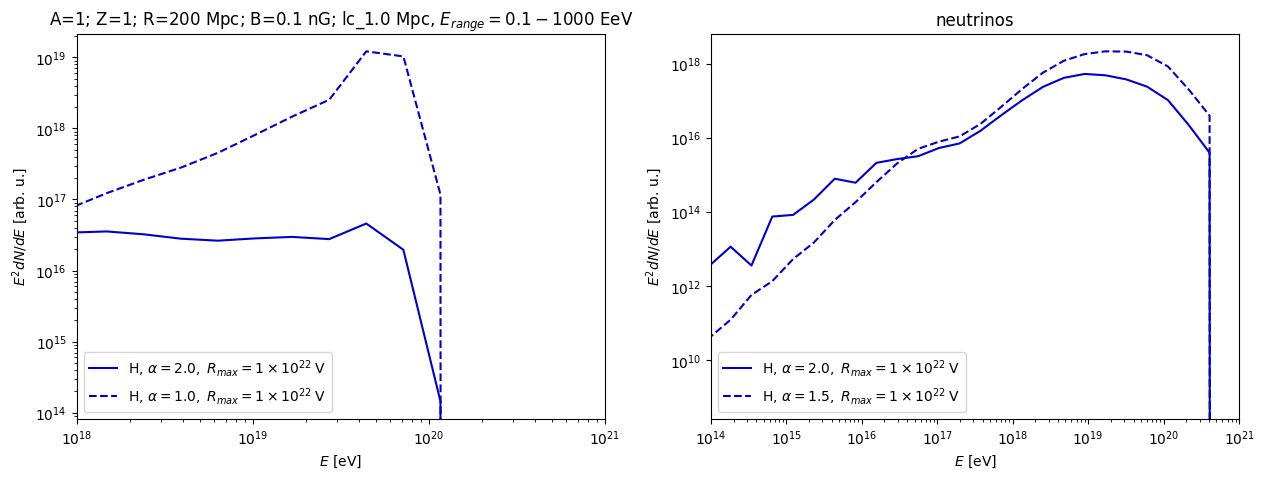

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figheight(5)
fig.set_figwidth(15)

ls1, ls2 = '-', '--'
cH, cN = 'mediumblue', 'firebrick'

ax1.plot(xH_CR_1, yH_CR_1, ls = ls1, c = cH, label = 'H, $\\alpha = 2.0, \\; R_{max} = 1 \\times 10^{22} \\; \\mathrm{V}$')
# ax1.plot(xN_CR_1, yN_CR_1, ls = ls1, c = cN, label = 'N, $\\alpha = 2.0, \\; R_{max} = 6 \\times 10^{19} \\; \\mathrm{V}$')
ax1.plot(xH_CR_2, yH_CR_2, ls = ls2, c = cH, label = 'H, $\\alpha = 1.0, \\; R_{max} = 1 \\times 10^{22} \\; \\mathrm{V}$')
# ax1.plot(xN_CR_2, yN_CR_2, ls = ls2, c = cN, label = 'N, $\\alpha = 1.5, \\; R_{max} = 4 \\times 10^{18} \\; \\mathrm{V}$')
ax1.set_title('A=1; Z=1; R=200 Mpc; B=0.1 nG; lc_1.0 Mpc, $E_{range}=0.1-1000$ EeV' )
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set(xlim = (1e18, 1e21))
ax1.set_ylabel('$E^2 dN/dE$ [arb. u.]')
ax1.set_xlabel('$E$ [eV]')
ax1.legend(loc = 'lower left')

ax2.plot(xH_Nu_1, yH_Nu_1, ls = ls1, c = cH, label = 'H, $\\alpha = 2.0, \\; R_{max} = 1 \\times 10^{22} \\; \\mathrm{V}$')
# ax2.plot(xN_Nu_1, yN_Nu_1, ls = ls1, c = cN, label = 'N, $\\alpha = 2.0, \\; R_{max} = 5 \\times 10^{19} \\; \\mathrm{V}$')
ax2.plot(xH_Nu_2, yH_Nu_2, ls = ls2, c = cH, label = 'H, $\\alpha = 1.5, \\; R_{max} = 1 \\times 10^{22} \\; \\mathrm{V}$')
# ax2.plot(xN_Nu_2, yN_Nu_2, ls = ls2, c = cN, label = 'N, $\\alpha = 1.5, \\; R_{max} = 6 \\times 10^{18} \\; \\mathrm{V}$')
ax2.set_title('neutrinos')
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set(xlim = (1e14, 1e21))
ax2.set_ylabel('$E^2 dN/dE$ [arb. u.]')
ax2.set_xlabel('$E$ [eV]')
ax2.legend(loc = 'lower left');

In [13]:
# -*- coding: utf-8 -*-
import sys
import numpy as np
from crpropa import *


def lmaxFromCohrenceLength(lmin, gridsize, compCoerencia):

        n=1000
        lmaxs=np.logspace(np.log10(lmin), np.log10(gridsize), n)

        lcs= [ turbulentCorrelationLength(lmin,lmax,-11/3) for lmax in lmaxs ]


        return  np.interp(compCoerencia, lcs,lmaxs)

NEvents = 100000//10 #números de eventos lidos via terminal
#supre = 'supression.txt'
A =1 #massa atômica
Z =1 #número atômico


#Volume da simulação

'''
        Aqui criamos uma 'caixa' na qual o ocorrerá a nossa simulação. Sendo mais específico, é a região na qual nosso campo mag-
        nético atua.
'''

boxOrigin = Vector3d(0, 0, 0) * Mpc
boxSize = 10 * Mpc
boxEdge = Vector3d(boxSize, boxSize, boxSize)



#Campo Magnético

'''
        Aqui vamos criar o campo magnético da simulação. Tratando-se de uma simualção 3d, usasse o Vector grid para guardar a infor-
        mações dos campo nos eixos (x,y,z) (usando a função VectorGrid)

        VectorGrid: o primeiro parâmetro da função é a origem da caixa de atuação do campo; o segundo é o número de células que irão
        preencer essa caixa ( pense num tabuleiro de xadrez em 3d); o terceiro é o tamanho de cada 'casa' desse tabuleiro de xadrez.

        initTurbulence: Essa função inicizaliza um campo turbulento aleatório. Seus parâmetro

                1°: vgrid-> é a grid inicializada com a Função VectorGrid
                2°: módulo do nosso campo magnético
                3°: lmin-> comprimento de onda  mínimo de oscilação turbulenta.
                4°: lmx-> comprimento de onda máximo de oscilação turbulenta.
                5°: índice da lei de potência( nesse caso temos o espectro de Kolmogorov)
                5°: seed
'''


B=float(100)

for i in range(0,10):

        randomSeed = i+1
        space = 0.1*Mpc
        lmax=lmaxFromCohrenceLength(space*2,boxSize,float(10)*Mpc) # gere o comprimento máximo ideal para o CL desejado
        # vgrid = VectorGrid(boxOrigin, 1024, space)
        vgrid = Grid3f(boxOrigin, 200, space)

        initTurbulence(vgrid, B*nG, space*2, lmax, -11/3, randomSeed)
        bField0 = MagneticFieldGrid(vgrid)
        bField = PeriodicMagneticField(bField0, Vector3d(4000, 4000, 4000) * Mpc, Vector3d(0), False)

        #Info

        '''
                Print de algumas informações do nosso campo.

        '''
        '''
        print("lmax={} e lmin={}".format(lmax/kpc,2*space/Mpc))
        print ("Lc = {}kpc".format(turbulentCorrelationLength( 2*space, lmax , -11./3.)/Mpc))  # correlation length
        print ("sqrt(<B^2>) = {} nG".format((rmsFieldStrength(vgrid) / nG)))   # RMS
        print ("<|B|> = {} nG".format((meanFieldStrength(vgrid) / nG)) ) # mean
        print ("B(10 Mpc, 0, 0) ={}nG".format(bField0.getField(Vector3d(10,0,0) * Mpc) / nG))


        '''

        #Observador

        '''
                A ideia de simulação é fazer uma geometria reversa na qual iremos posicionar a fonte dentro de uma esfera de raio R(distância
                da fonte desejada até a terra). Nesta simulação, a fonte é CenA que está a uma distância de 3.7 Mpc da terra.

                A esfera em questão é a Terra.

                As funções nessa região são intuitivas.
        '''

        # r=float(sys.argv[3])
        r=3.7

        out = TextOutput("test.txt")
        obs = Observer()
        obs.add((ObserverSurface( Sphere(Vector3d(0,0,0), r*Mpc)) ))
        obs.onDetection(out)


        # module setup
        sim = ModuleList()
        #sim.add(SimplePropagation())
        sim.add(PropagationBP(bField,1e-3,1*kpc,10*kpc))
        sim.add(PhotoPionProduction(CMB()))
        sim.add(PhotoPionProduction(CMB()))
        sim.add(PhotoPionProduction(IRB_Gilmore12()))
        sim.add(PhotoDisintegration(CMB()))
        sim.add(PhotoDisintegration(IRB_Gilmore12()))
        sim.add(NuclearDecay())
        sim.add(ElectronPairProduction(CMB()))
        sim.add(ElectronPairProduction(IRB_Gilmore12()))
        sim.add(MinimumEnergy(0.01 * EeV))
        sim.add(Redshift())
        sim.add(MaximumTrajectoryLength(4000 * Mpc))

        #fonte


        '''
                A fonte irá emitir somente prótons isotropicamente. A energia de emissão varia de 1e17 até 1e21
        '''
        source = Source()
        source.add(SourcePosition(Vector3d(0, 0, 0)))
        source.add(SourceIsotropicEmission())
        source.add(SourceParticleType(nucleusId(A,Z)))
        source.add(SourcePowerLawSpectrum(1e17 * eV, 1e21 * eV, -1.))
        #source.add(SourceEnergy(E*EeV))
        sim.add(obs)



        #execute
        sim.setShowProgress(True)
        sim.run(source, NEvents, True)



2025-02-13 12:20:15 [WARNING] turbulentCorrelationLength is deprecated and will be removed in the future. Replace it with a more appropriate turbulent field model and call getCorrelationLength().
2025-02-13 12:20:15 [WARNING] turbulentCorrelationLength is deprecated and will be removed in the future. Replace it with a more appropriate turbulent field model and call getCorrelationLength().
2025-02-13 12:20:15 [WARNING] turbulentCorrelationLength is deprecated and will be removed in the future. Replace it with a more appropriate turbulent field model and call getCorrelationLength().
2025-02-13 12:20:15 [WARNING] turbulentCorrelationLength is deprecated and will be removed in the future. Replace it with a more appropriate turbulent field model and call getCorrelationLength().
2025-02-13 12:20:15 [WARNING] turbulentCorrelationLength is deprecated and will be removed in the future. Replace it with a more appropriate turbulent field model and call getCorrelationLength().
2025-02-13 12:20:15 

crpropa::ModuleList: Number of Threads: 12
Run ModuleList
  Started Thu Feb 13 12:20:18 2025 : [ Finished ] 100%    Needed: 00:00:00  - Finished at Thu Feb 13 12:20:18 2025


2025-02-13 12:20:18 [WARNING] turbulentCorrelationLength is deprecated and will be removed in the future. Replace it with a more appropriate turbulent field model and call getCorrelationLength().
2025-02-13 12:20:18 [WARNING] turbulentCorrelationLength is deprecated and will be removed in the future. Replace it with a more appropriate turbulent field model and call getCorrelationLength().
2025-02-13 12:20:18 [WARNING] turbulentCorrelationLength is deprecated and will be removed in the future. Replace it with a more appropriate turbulent field model and call getCorrelationLength().
2025-02-13 12:20:18 [WARNING] turbulentCorrelationLength is deprecated and will be removed in the future. Replace it with a more appropriate turbulent field model and call getCorrelationLength().
2025-02-13 12:20:18 [WARNING] turbulentCorrelationLength is deprecated and will be removed in the future. Replace it with a more appropriate turbulent field model and call getCorrelationLength().
2025-02-13 12:20:18 

crpropa::ModuleList: Number of Threads: 12
Run ModuleList
  Started Thu Feb 13 12:20:21 2025 : [ Finished ] 100%    Needed: 00:00:00  - Finished at Thu Feb 13 12:20:21 2025


2025-02-13 12:20:21 [WARNING] turbulentCorrelationLength is deprecated and will be removed in the future. Replace it with a more appropriate turbulent field model and call getCorrelationLength().
2025-02-13 12:20:21 [WARNING] turbulentCorrelationLength is deprecated and will be removed in the future. Replace it with a more appropriate turbulent field model and call getCorrelationLength().
2025-02-13 12:20:21 [WARNING] turbulentCorrelationLength is deprecated and will be removed in the future. Replace it with a more appropriate turbulent field model and call getCorrelationLength().
2025-02-13 12:20:21 [WARNING] turbulentCorrelationLength is deprecated and will be removed in the future. Replace it with a more appropriate turbulent field model and call getCorrelationLength().
2025-02-13 12:20:21 [WARNING] turbulentCorrelationLength is deprecated and will be removed in the future. Replace it with a more appropriate turbulent field model and call getCorrelationLength().
2025-02-13 12:20:21 

crpropa::ModuleList: Number of Threads: 12
Run ModuleList
  Started Thu Feb 13 12:20:24 2025 : [ Finished ] 100%    Needed: 00:00:00  - Finished at Thu Feb 13 12:20:24 2025


2025-02-13 12:20:24 [WARNING] turbulentCorrelationLength is deprecated and will be removed in the future. Replace it with a more appropriate turbulent field model and call getCorrelationLength().
2025-02-13 12:20:24 [WARNING] turbulentCorrelationLength is deprecated and will be removed in the future. Replace it with a more appropriate turbulent field model and call getCorrelationLength().
2025-02-13 12:20:24 [WARNING] turbulentCorrelationLength is deprecated and will be removed in the future. Replace it with a more appropriate turbulent field model and call getCorrelationLength().
2025-02-13 12:20:24 [WARNING] turbulentCorrelationLength is deprecated and will be removed in the future. Replace it with a more appropriate turbulent field model and call getCorrelationLength().
2025-02-13 12:20:24 [WARNING] turbulentCorrelationLength is deprecated and will be removed in the future. Replace it with a more appropriate turbulent field model and call getCorrelationLength().
2025-02-13 12:20:24 

crpropa::ModuleList: Number of Threads: 12
Run ModuleList
  Started Thu Feb 13 12:20:27 2025 : [ Finished ] 100%    Needed: 00:00:00  - Finished at Thu Feb 13 12:20:27 2025


2025-02-13 12:20:27 [WARNING] turbulentCorrelationLength is deprecated and will be removed in the future. Replace it with a more appropriate turbulent field model and call getCorrelationLength().
2025-02-13 12:20:27 [WARNING] turbulentCorrelationLength is deprecated and will be removed in the future. Replace it with a more appropriate turbulent field model and call getCorrelationLength().
2025-02-13 12:20:27 [WARNING] turbulentCorrelationLength is deprecated and will be removed in the future. Replace it with a more appropriate turbulent field model and call getCorrelationLength().
2025-02-13 12:20:27 [WARNING] turbulentCorrelationLength is deprecated and will be removed in the future. Replace it with a more appropriate turbulent field model and call getCorrelationLength().
2025-02-13 12:20:27 [WARNING] turbulentCorrelationLength is deprecated and will be removed in the future. Replace it with a more appropriate turbulent field model and call getCorrelationLength().
2025-02-13 12:20:27 

crpropa::ModuleList: Number of Threads: 12
Run ModuleList
  Started Thu Feb 13 12:20:30 2025 : [ Finished ] 100%    Needed: 00:00:00  - Finished at Thu Feb 13 12:20:30 2025


2025-02-13 12:20:30 [WARNING] turbulentCorrelationLength is deprecated and will be removed in the future. Replace it with a more appropriate turbulent field model and call getCorrelationLength().
2025-02-13 12:20:30 [WARNING] turbulentCorrelationLength is deprecated and will be removed in the future. Replace it with a more appropriate turbulent field model and call getCorrelationLength().
2025-02-13 12:20:30 [WARNING] turbulentCorrelationLength is deprecated and will be removed in the future. Replace it with a more appropriate turbulent field model and call getCorrelationLength().
2025-02-13 12:20:30 [WARNING] turbulentCorrelationLength is deprecated and will be removed in the future. Replace it with a more appropriate turbulent field model and call getCorrelationLength().
2025-02-13 12:20:30 [WARNING] turbulentCorrelationLength is deprecated and will be removed in the future. Replace it with a more appropriate turbulent field model and call getCorrelationLength().
2025-02-13 12:20:30 

crpropa::ModuleList: Number of Threads: 12
Run ModuleList
  Started Thu Feb 13 12:20:32 2025 : [ Finished ] 100%    Needed: 00:00:00  - Finished at Thu Feb 13 12:20:32 2025


2025-02-13 12:20:32 [WARNING] turbulentCorrelationLength is deprecated and will be removed in the future. Replace it with a more appropriate turbulent field model and call getCorrelationLength().
2025-02-13 12:20:32 [WARNING] turbulentCorrelationLength is deprecated and will be removed in the future. Replace it with a more appropriate turbulent field model and call getCorrelationLength().
2025-02-13 12:20:32 [WARNING] turbulentCorrelationLength is deprecated and will be removed in the future. Replace it with a more appropriate turbulent field model and call getCorrelationLength().
2025-02-13 12:20:32 [WARNING] turbulentCorrelationLength is deprecated and will be removed in the future. Replace it with a more appropriate turbulent field model and call getCorrelationLength().
2025-02-13 12:20:32 [WARNING] turbulentCorrelationLength is deprecated and will be removed in the future. Replace it with a more appropriate turbulent field model and call getCorrelationLength().
2025-02-13 12:20:32 

crpropa::ModuleList: Number of Threads: 12
Run ModuleList
  Started Thu Feb 13 12:20:35 2025 : [ Finished ] 100%    Needed: 00:00:00  - Finished at Thu Feb 13 12:20:35 2025


2025-02-13 12:20:35 [WARNING] turbulentCorrelationLength is deprecated and will be removed in the future. Replace it with a more appropriate turbulent field model and call getCorrelationLength().
2025-02-13 12:20:35 [WARNING] turbulentCorrelationLength is deprecated and will be removed in the future. Replace it with a more appropriate turbulent field model and call getCorrelationLength().
2025-02-13 12:20:35 [WARNING] turbulentCorrelationLength is deprecated and will be removed in the future. Replace it with a more appropriate turbulent field model and call getCorrelationLength().
2025-02-13 12:20:35 [WARNING] turbulentCorrelationLength is deprecated and will be removed in the future. Replace it with a more appropriate turbulent field model and call getCorrelationLength().
2025-02-13 12:20:35 [WARNING] turbulentCorrelationLength is deprecated and will be removed in the future. Replace it with a more appropriate turbulent field model and call getCorrelationLength().
2025-02-13 12:20:35 

crpropa::ModuleList: Number of Threads: 12
Run ModuleList
  Started Thu Feb 13 12:20:37 2025 : [ Finished ] 100%    Needed: 00:00:00  - Finished at Thu Feb 13 12:20:37 2025


2025-02-13 12:20:37 [WARNING] turbulentCorrelationLength is deprecated and will be removed in the future. Replace it with a more appropriate turbulent field model and call getCorrelationLength().
2025-02-13 12:20:37 [WARNING] turbulentCorrelationLength is deprecated and will be removed in the future. Replace it with a more appropriate turbulent field model and call getCorrelationLength().
2025-02-13 12:20:37 [WARNING] turbulentCorrelationLength is deprecated and will be removed in the future. Replace it with a more appropriate turbulent field model and call getCorrelationLength().
2025-02-13 12:20:37 [WARNING] turbulentCorrelationLength is deprecated and will be removed in the future. Replace it with a more appropriate turbulent field model and call getCorrelationLength().
2025-02-13 12:20:37 [WARNING] turbulentCorrelationLength is deprecated and will be removed in the future. Replace it with a more appropriate turbulent field model and call getCorrelationLength().
2025-02-13 12:20:37 

crpropa::ModuleList: Number of Threads: 12
Run ModuleList
  Started Thu Feb 13 12:20:40 2025 : [ Finished ] 100%    Needed: 00:00:00  - Finished at Thu Feb 13 12:20:40 2025


2025-02-13 12:20:40 [WARNING] turbulentCorrelationLength is deprecated and will be removed in the future. Replace it with a more appropriate turbulent field model and call getCorrelationLength().
2025-02-13 12:20:40 [WARNING] turbulentCorrelationLength is deprecated and will be removed in the future. Replace it with a more appropriate turbulent field model and call getCorrelationLength().
2025-02-13 12:20:40 [WARNING] turbulentCorrelationLength is deprecated and will be removed in the future. Replace it with a more appropriate turbulent field model and call getCorrelationLength().
2025-02-13 12:20:40 [WARNING] turbulentCorrelationLength is deprecated and will be removed in the future. Replace it with a more appropriate turbulent field model and call getCorrelationLength().
2025-02-13 12:20:40 [WARNING] turbulentCorrelationLength is deprecated and will be removed in the future. Replace it with a more appropriate turbulent field model and call getCorrelationLength().
2025-02-13 12:20:40 

crpropa::ModuleList: Number of Threads: 12
Run ModuleList
  Started Thu Feb 13 12:20:43 2025 : [ Finished ] 100%    Needed: 00:00:00  - Finished at Thu Feb 13 12:20:43 2025


In [9]:
vgrid = Grid3f(boxOrigin, 50, space)
vgrid

<Swig Object of type 'crpropa::Grid3f *' at 0x7f33d4111db0>